In [46]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
import os
import re
from time import perf_counter
import boost_histogram as bh

In [47]:
def make_dict(name, files):
    t_dict = {}
    t_dict['data'] = files
    for reg in all_reg:
        t_dict[reg] = Systogram(bh.axis.Regular(*bin_meta), storage=bh.storage.Weight(), metadata='DiLepMass ({}/{})'.format(name,reg))
    return t_dict

In [48]:
era = 2016
regex_select = "tw_{}.+\.csv".format(era)
files = [x for x in os.listdir('data') if re.match(regex_select, x)]
DY = [x for x in files if re.match('.+ZTo(?:Mu|EE).+', x)]
ST = [x for x in files if re.match('.+top.csv', x)]
VB = [x for x in files if re.match('.+mc_(?:ww|wz|zz)', x)]
TT = [x for x in files if re.match('.+ttbar', x)]
BFF = [x for x in files if re.match('.+BFFZp', x)]
data = [x for x in files if re.match('.+_data_', x)]
assert len(files) == len(DY+ST+TT+VB+data+BFF), "duplicate or uncaught file"

In [49]:
bin_meta = [int((800-105)/5+1),105,800]
DY_dict = make_dict('DY', DY)
ST_dict = make_dict('ST', ST)
TT_dict = make_dict('TT', TT)
VB_dict = make_dict('VB', VB)
data_dict = make_dict('data', data)
bff_list = []
for bff in BFF:
    name = re.findall('tw_[0-9]+_(.+).csv',bff)[0]
    bff_list.append(make_dict(name, [bff]))

In [50]:
print(data_dict)

{'data': ['tw_2016_data_el.csv', 'tw_2016_data_mu.csv'], 'SR1': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'SR2': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR10': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR20': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR13': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR23': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR14': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR24': Systogram(Regular(140, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}


In [51]:
bin_meta = [int((800-105)/5+1),105,800]
column = 'DiLepMass'

In [52]:
def process_sample(df, hist_dict, bff_cv=BFF_cut_values, ismc=0, blinded=True):
    start = perf_counter()
    for reg in all_reg:
        rdf = bff_cuts_pd(df, reg, 'nominal', bff_cv=bff_cv)
        #remove blinded data
        if  (not ismc) and blinded and ('SR' in reg): continue
        hist_dict[reg].fill(rdf['DiLepMass'], weight=rdf['Weight'])
        if ismc:
            for wup, wdown in weights:
                w = wup.replace('Up','')
                hist_dict[reg].get_sys(w)['up'].fill(rdf['DiLepMass'], weight=rdf[wup])
                hist_dict[reg].get_sys(w)['down'].fill(rdf['DiLepMass'], weight=rdf[wdown])    
            for jvup, jvdown in jet_variations:
                jv = jvup.replace('Up','')
                rdfup = bff_cuts_pd(df, reg, jvup)
                hist_dict[reg].get_sys(jv)['up'].fill(rdfup['DiLepMass'], weight=rdfup['Weight'])
                rdfdown = bff_cuts_pd(df, reg, jvdown)
                hist_dict[reg].get_sys(jv)['down'].fill(rdfdown['DiLepMass'], weight=rdfdown['Weight'])
    print(perf_counter()-start)
    return hist_dict

def process_all_sample(s_dict, **kwargs):
    for files in s_dict['data']:
        print(files)
        df = pd.read_csv('data/'+files)
        process_sample(df, s_dict, **kwargs)

In [53]:
process_all_sample(DY_dict,ismc=1)
process_all_sample(ST_dict,ismc=1)
process_all_sample(TT_dict,ismc=1)
process_all_sample(VB_dict,ismc=1)
process_all_sample(data_dict,ismc=0)
for bff in bff_list:
    process_all_sample(bff,ismc=1)

tw_2016_ZToMuMu_M_400_800.csv
0.5149880150020181
tw_2016_ZToMuMu_M_200_400.csv
0.356775058000494
tw_2016_ZToEE_M_400_800.csv
0.34095883600093657
tw_2016_ZToEE_M_200_400.csv
0.586916554999334
tw_2016_ZToMuMu_M_120_200.csv
0.3419921530003194
tw_2016_ZToEE_M_800_1400.csv
0.3213938839980983
tw_2016_ZToMuMu_M_50_120.csv
0.2971746559996973
tw_2016_ZToMuMu_M_800_1400.csv
0.32234336500187055
tw_2016_ZToEE_M_50_120.csv
0.29860410499895806
tw_2016_ZToEE_M_120_200.csv
0.3895937220004271
tw_2016_mc_stop.csv
0.3479391910004779
tw_2016_mc_santitop.csv
0.32565375299964217
tw_2016_mc_ttbar.csv
3.479951264002011
tw_2016_mc_ww.csv
0.4436876809995738
tw_2016_mc_zz.csv
0.32541917799972
tw_2016_mc_wz.csv
0.33687063199977274
tw_2016_data_el.csv
0.12351801000113483
tw_2016_data_mu.csv
0.14101802599907387
tw_2016_BFFZprimeToMuMu_M_200.csv
0.9087746660006815
tw_2016_BFFZprimeToMuMu_M_500_dbs1p0.csv
0.849771700999554
tw_2016_BFFZprimeToMuMu_M_200_dbs0p5.csv
0.7900839799985988
tw_2016_BFFZprimeToMuMu_M_500_dbs0p

In [54]:
processed_stuff = {
"DY_dict":DY_dict,
"ST_dict":ST_dict,
"TT_dict":TT_dict,
"VB_dict":VB_dict,
"data_dict":data_dict,
"bff_list":bff_list,
}
import pickle
outname="2016_functional_plotter.pkl"
with open(outname,'wb') as f:
    pickle.dump(processed_stuff, f)

In [55]:
reg = 'CR10'
center = DY_dict[reg].axes[0].centers
DY_nom, DY_up, DY_down = DY_dict[reg].nom_std_arrays()
TT_nom, TT_up, TT_down = TT_dict[reg].nom_std_arrays()
ST_nom, ST_up, ST_down = ST_dict[reg].nom_std_arrays()
VB_nom, VB_up, VB_down = VB_dict[reg].nom_std_arrays()
bff_plt_list = [x[reg].nom_std_arrays() for x in  bff_list]
data_nom,data_err  = data_dict[reg].values(),  data_dict[reg].variances()


(0.1, 100000.0)

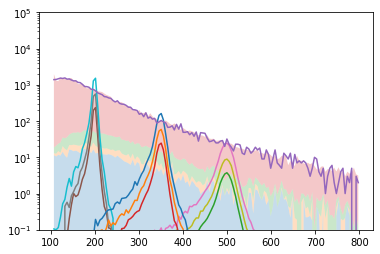

In [56]:
import matplotlib.pyplot as plt
plt.stackplot(center, [VB_nom,ST_nom,TT_nom,DY_nom], alpha=.25)
plt.errorbar(center, data_nom)
for nom,up, down in bff_plt_list:
    plt.plot(center, nom)
#plt.fill_between(center, up, down, alpha=.25)
plt.yscale('log')
plt.ylim(bottom=1e-1, top=1e5)